In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
from dotenv import dotenv_values
from locus.utils.paths import SQL_DIR
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm

%matplotlib widget

In [2]:
config = dotenv_values("../.env")
conn = psycopg2.connect(
    host=config["DB_HOST"],
    port=config["DB_PORT"],
    dbname=config["DB_NAME"],
    user=config["DB_USER"],
    password=config["DB_PASSWORD"],
)
cur = conn.cursor()

In [3]:
with open(SQL_DIR / "select_count_lat_lon.sql", "r") as f:
    get_count_sql_template = f.read()

In [4]:
n_rows = 180
n_cols = 360

heatmap_data = np.empty([n_rows, n_cols])

for i in tqdm(range(n_rows)):
    for j in range(n_cols):
        north = -90 + 180 * ((n_rows-i) / n_rows)
        south = -90 + 180 * ((n_rows-i - 1) / n_rows)

        west = -180 + 360 * (j / n_cols)
        east = -180 + 360 * ((j + 1) / n_cols)

        # print(f"{west=:.2f} {east=:.2f} {north=:.2f} {south=:.2f}")

        cur.execute(get_count_sql_template.format(south, north, west, east, 10e9))
        heatmap_data[i, j] = cur.fetchone()[0]

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [1:39:15<00:00, 33.09s/it]


In [14]:
def draw_screen_poly(lats, lons, m, res, density, max_density):
    # Convert to linspace
    lats_linspace = np.linspace(lats[0], lats[1], res)
    lons_linspace = np.linspace(lons[0], lons[1], res)

    # Define the edge points' coordinates
    west_edge_lats = lats_linspace
    west_edge_lons = [lons_linspace[0]] * res
    north_edge_lats = [lats_linspace[-1]] * res
    north_edge_lons = lons_linspace
    east_edge_lats = lats_linspace[::-1]
    east_edge_lons = [lons_linspace[-1]] * res
    south_edge_lats = [lats_linspace[0]] * res
    south_edge_lons = lons_linspace[::-1]

    

    # Convert to map projection
    geo_rect_lats = np.concatenate(
        [
            west_edge_lats,
            north_edge_lats,
            east_edge_lats,
            south_edge_lats,
        ]
    )
    geo_rect_lons = np.concatenate(
        [
            west_edge_lons,
            north_edge_lons,
            east_edge_lons,
            south_edge_lons,
        ]
    )
    x, y = m(geo_rect_lons, geo_rect_lats)

    xy = zip(x, y)

    # get random color
    cmap = matplotlib.cm.get_cmap('viridis')
    facecolor = cmap(np.log(density)/np.log(max_density))

    poly = Polygon(list(xy), facecolor=facecolor, alpha=1)
    plt.gca().add_patch(poly)

  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipykernel_47569/2678723997.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')
100%|██████████| 180/180 [00:12<00:00, 14.84it/s]


{-180.0: ([<matplotlib.lines.Line2D at 0x7fd7b0096610>], []),
 -157.5: ([<matplotlib.lines.Line2D at 0x7fd7a2eb5790>], []),
 -135.0: ([<matplotlib.lines.Line2D at 0x7fd7a311e290>], []),
 -112.5: ([<matplotlib.lines.Line2D at 0x7fd7a36ded90>], []),
 -90.0: ([<matplotlib.lines.Line2D at 0x7fd7a2eb7890>], []),
 -67.5: ([<matplotlib.lines.Line2D at 0x7fd7a32fc3d0>], []),
 -45.0: ([<matplotlib.lines.Line2D at 0x7fd7a3bcced0>], []),
 -22.5: ([<matplotlib.lines.Line2D at 0x7fd7a311d9d0>], []),
 0.0: ([<matplotlib.lines.Line2D at 0x7fd7a2ec6490>], []),
 22.5: ([<matplotlib.lines.Line2D at 0x7fd7a32fef90>], []),
 45.0: ([<matplotlib.lines.Line2D at 0x7fd7a32bfa90>], []),
 67.5: ([<matplotlib.lines.Line2D at 0x7fd7a34d45d0>], []),
 90.0: ([<matplotlib.lines.Line2D at 0x7fd7a2ecd010>], []),
 112.5: ([<matplotlib.lines.Line2D at 0x7fd7a2ecdb50>], []),
 135.0: ([<matplotlib.lines.Line2D at 0x7fd7a2ece710>], []),
 157.5: ([<matplotlib.lines.Line2D at 0x7fd7a34d71d0>], []),
 180.0: ([<matplotlib.line

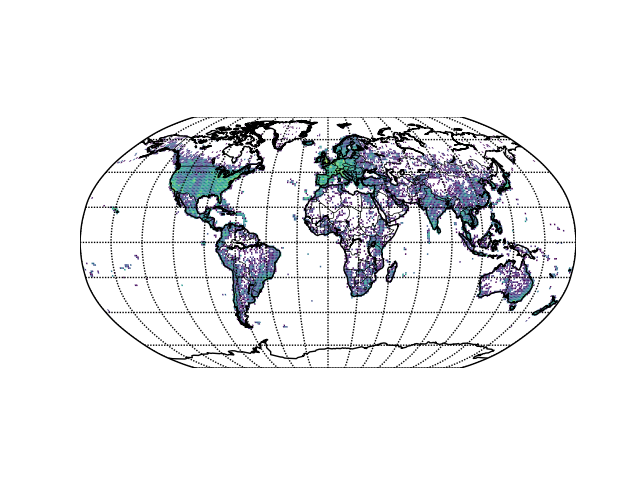

In [15]:
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.


fig, ax = plt.subplots()  # a figure with a single Axes
m = Basemap(projection="robin", lon_0=0, resolution="c")


# Draw coastlines and countries

# m.drawmapboundary(fill_color="aqua")


res = 10

max_density = heatmap_data.max()
for i in tqdm(range(n_rows)):
    for j in range(n_cols):

        density = heatmap_data[i, j]
        if not density:
            continue
        north = -90 + 180 * ((n_rows - i) / n_rows)
        south = -90 + 180 * ((n_rows - i - 1) / n_rows)

        west = -180 + 360 * (j / n_cols)
        east = -180 + 360 * ((j + 1) / n_cols)

        # print(f"{west=:.2f} {east=:.2f} {north=:.2f} {south=:.2f}")
        # heatmap_data[i, j]

        draw_screen_poly(
            (south, north), (west, east), m, res, density=density, max_density=max_density
        )

m.drawcoastlines()
m.drawcountries()
# m = Basemap(projection="robin", lon_0=0, resolution="c")
# m.fillcontinents(color="coral", lake_color="aqua")
# # draw parallels and meridians.
m.drawparallels(np.arange(-90.0, 120.0, 22.5))
m.drawmeridians(np.arange(0.0, 360.0, 22.5))

In [8]:
np.save('heatmap_data.npy', heatmap_data)

In [12]:
heatmap_data.max()

124974.0

In [11]:
arr = np.load('heatmap_data.npy')

print("Array loaded from file:")
print(arr.max())

Array loaded from file:
124974.0


In [13]:
plt.savefig("heatmap_data.svg", bbox_inches='tight', transparent=True,
               pad_inches=0, format="svg")

/tmp/ipykernel_47569/3010925863.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  heatmap = m.pcolormesh(x, y, data, cmap='viridis', norm=norm)


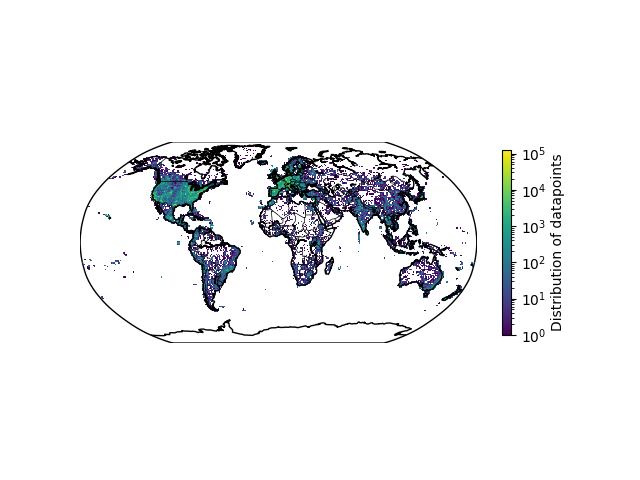

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors

fig, ax = plt.subplots()

# Generate some random heatmap data
data = heatmap_data[::-1, :]
data[data == 0] = 1e-1  # Set zero values to a small non-zero value to avoid log(0)

# Create a Basemap instance
m = Basemap(projection="robin", lon_0=0, resolution="c")

# Convert lat/lon to map coordinates
lon = np.linspace(-180, 180, 360)  # Example longitudes
lat = np.linspace(-90, 90, 180)     # Example latitudes
lon, lat = np.meshgrid(lon, lat)
x, y = m(lon, lat)

# Draw the map
m.drawcoastlines()
m.drawcountries()

# Create a logarithmic color scale
norm = mcolors.LogNorm(vmin=1e0, vmax=np.nanmax(data))

# Plot the heatmap with logarithmic color scale
heatmap = m.pcolormesh(x, y, data, cmap='viridis', norm=norm)

# Add colorbar
cbar = plt.colorbar(heatmap, orientation='vertical', shrink=0.5)
cbar.set_label('Distribution of datapoints')
plt.savefig("heatmap_data.svg", bbox_inches='tight', transparent=True,
               pad_inches=0, format="svg")

plt.savefig('heatmap.png', dpi=300)  # dpi sets the resolution, adjust as needed
# Show the plot
plt.show()